# Stochastic Differential Equations (SDEs) and Random ODEs (RODEs)

- [Wikipedia: Stochastic Differential Equations](https://en.wikipedia.org/wiki/Stochastic_differential_equation)
- [SDE example](https://diffeq.sciml.ai/stable/tutorials/sde_example/) in `DifferentialEquations.jl`
- [RODE example](https://diffeq.sciml.ai/stable/tutorials/rode_example/) in `DifferentialEquations.jl`

## Stochastic Differential Equations (SDEs)

### Scalar SDEs with one state variable

Solving the equation: $du=f(u,p,t)dt + g(u,p,t)dW$

- $f(u,p,t)$ is the ordinary differential equations (ODEs) part
- $g(u,p,t)$ is the stochastic part, paired with a Brownian motion term $dW$.

If $f(u,p,t) = \alpha u$ and $g(u,p,t) = \beta u$, the analytical solution is $u(t, W_t) = u_0 exp((\alpha - \frac{\beta^2}{2})t + \beta W_t)$

In [1]:
using DifferentialEquations
using Plots

f(u, p, t) = p.α * u
g(u, p, t) = p.β * u

p = (α=1, β=1)
u₀ = 1/2
dt = 1//2^(4)
tspan = (0.0,1.0)
prob = SDEProblem(f, g, u₀, (0.0, 1.0), p)

SDEProblem with uType Float64 and tType Float64. In-place: false
timespan: (0.0, 1.0)
u0: 0.5

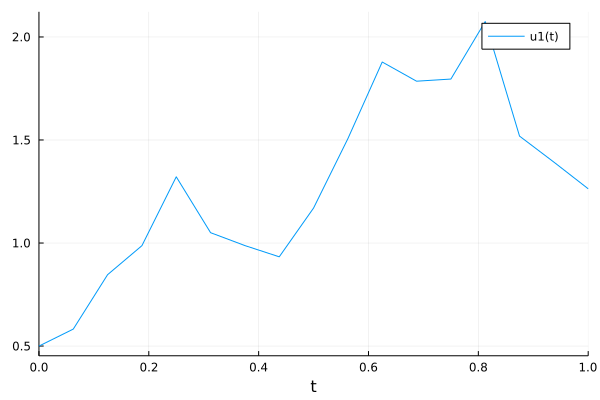

In [2]:
# use the classic Euler-Maruyama algorithm
sol = solve(prob, EM(), dt=dt)
plot(sol)

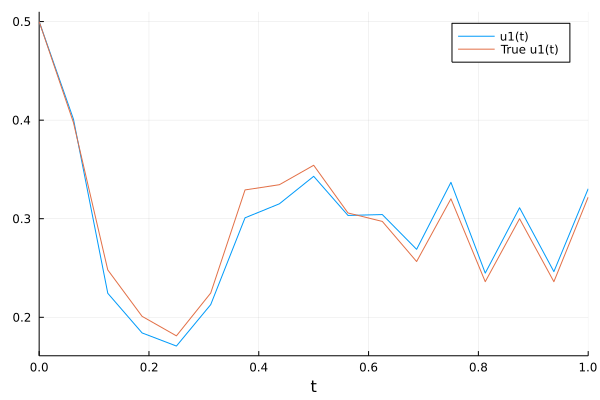

In [3]:
# Compare to the analytical soolution
f_analytic(u₀, p, t, W) = u₀ * exp((p.α - (p.β^2) / 2) * t + p.β * W)
# Combine model and analytic functions
ff = SDEFunction(f, g, analytic=f_analytic)
prob = SDEProblem(ff, g, u₀, (0.0,1.0), p)
sol = solve(prob, EM(), dt=dt)
plot(sol, plot_analytic=true)

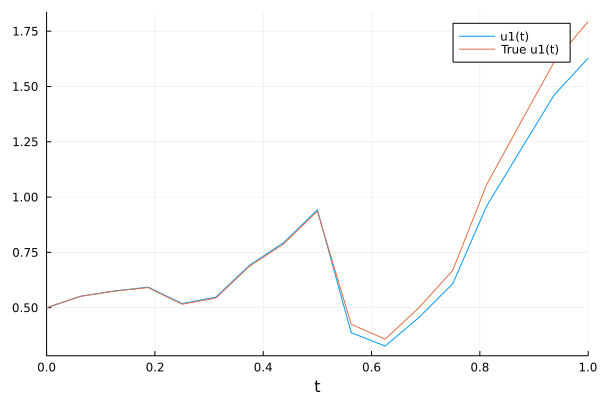

In [4]:
# choose a higher-order solver for a more accurate result
sol = solve(prob, SRIW1(), dt=dt, adaptive=false)
plot(sol, plot_analytic=true)

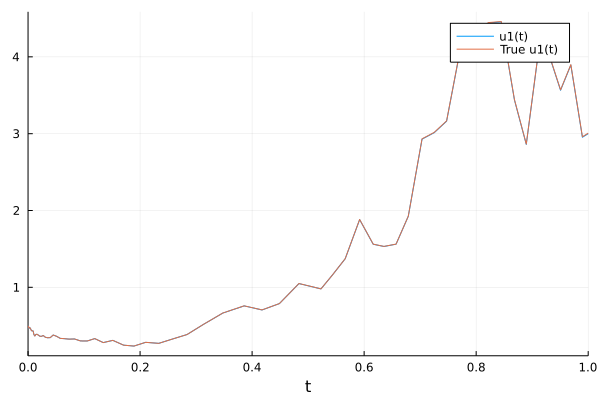

In [5]:
# The solver can find dt itself
sol = solve(prob, SRIW1())
plot(sol, plot_analytic=true)

### Diagonal Noise

Each state variable are subject to its own noise.

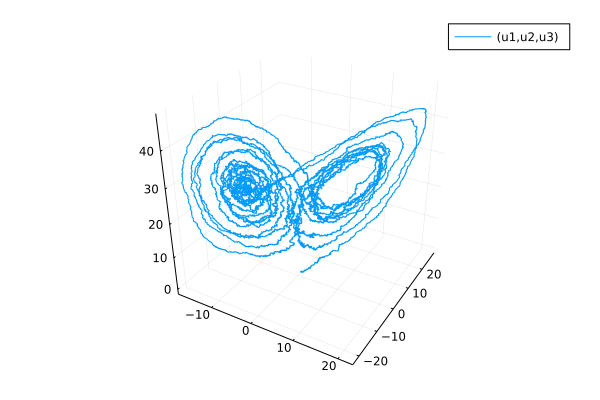

In [6]:
using DifferentialEquations
using Plots

function lorenz!(du, u, p, t)
    du[1] = 10.0(u[2]-u[1])
    du[2] = u[1]*(28.0-u[3]) - u[2]
    du[3] = u[1]*u[2] - (8/3)*u[3]
end
  
function σ_lorenz!(du, u, p, t)
    du[1] = 3.0
    du[2] = 3.0
    du[3] = 3.0
end
  
prob_sde_lorenz = SDEProblem(lorenz!, σ_lorenz!, [1.0, 0.0, 0.0], (0.0, 20.0))
sol = solve(prob_sde_lorenz)

plot(sol, vars=(1,2,3))

### Scalar Noise

The same noise process (`W`) is applied to all state variables.

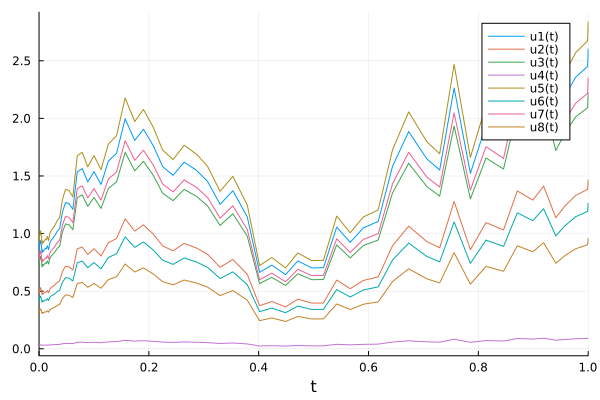

In [7]:
using DifferentialEquations
using Plots

f(du, u, p, t) = (du .= u)
g(du, u, p, t) = (du .= u)
u0 = rand(4, 2)

W = WienerProcess(0.0, 0.0, 0.0)
prob = SDEProblem(f, g, u0, (0.0,1.0), noise=W)
sol = solve(prob, SRIW1())
plot(sol)

### Non-Diagonal (matrix) Noise

A more general type of noise allows for the terms to linearly mixed via noise function `g` being a matrix.

$$ 
\begin{aligned}
du_1 &= f_1(u,p,t)dt + g_{11}(u,p,t)dW_1 + g_{12}(u,p,t)dW_2 + g_{13}(u,p,t)dW_3 + g_{14}(u,p,t)dW_4  \\
du_2 &= f_2(u,p,t)dt + g_{21}(u,p,t)dW_1 + g_{22}(u,p,t)dW_2 + g_{23}(u,p,t)dW_3 + g_{24}(u,p,t)dW_4
\end{aligned}
$$

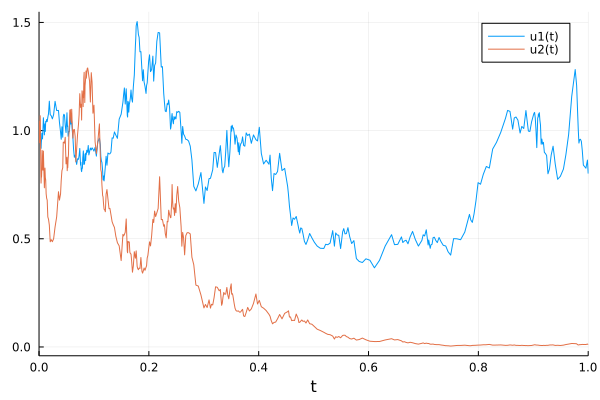

In [8]:
using DifferentialEquations
using Plots

# Model function
function f(du, u, p, t) 
    du .= 1.01u
end

# Noise function
function g(du, u, p, t)
  du[1,1] = 0.3u[1]
  du[1,2] = 0.6u[1]
  du[1,3] = 0.9u[1]
  du[1,4] = 0.12u[1]
  du[2,1] = 1.2u[2]
  du[2,2] = 0.2u[2]
  du[2,3] = 0.3u[2]
  du[2,4] = 1.8u[2]
end

u0 = ones(2)
tspan = (0.0, 1.0)

# The noise matrix itself is determined by the keyword argument noise_rate_prototype
prob = SDEProblem(f, g, u0, tspan, noise_rate_prototype=zeros(2, 4))

sol = solve(prob)
plot(sol)

### Recommended SDE solvers

From: https://diffeq.sciml.ai/stable/solvers/sde_solve/#sde_solve

- `EM` / `EulerHeun`: non-adaptive (fixed `dt`)
- `SOSRI`: for most Ito diagonal and scalar noise problems
- `SOSRA`: additive noise
- `SRA3`: low tolerances (<`1e-4`?)
- `RKMilCommute`: commutative noise
- `LambaEM` / `LambaEulerHeun`: Non-diagonal problems
- `ImplicitRKMil`: stiff problems with small diagonal noise
- `DRI1`: a high number of Wiener processes

## Random ODEs

Random ODEs (RODEs) is a more general form that allows nonlinear mixings of randomness. 

$du = f(u, p, t, W) dt$ where $W(t)$ is a Wiener process (Gaussian process).

`RODEProblem(f, u0, tspan [, params])` constructs an RODE problem. 

The model function signature is
- `f(u, p, t, W)` (out-of-place form).
- `f(du, u, p, t, W)` (in-place form).

### Scalar RODEs

$du = f(u,p,t,W) = 2usin(W)$

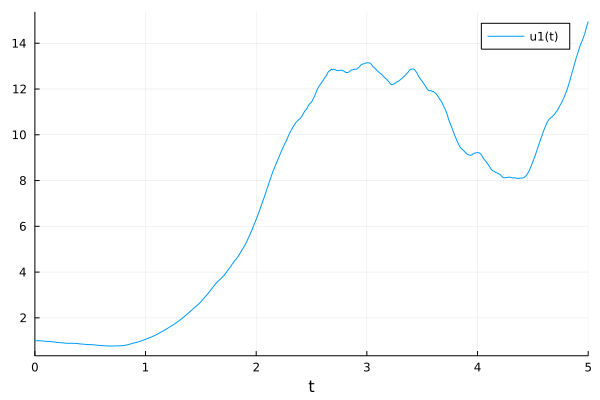

In [9]:
using DifferentialEquations
using Plots

function f(u, p, t, W)
  2u * sin(W)
end

u0 = 1.00
tspan = (0.0, 5.0)
prob = RODEProblem(f, u0, tspan)
sol = solve(prob, RandomEM(), dt=1/100)

plot(sol)

### Systems of RODEs

Using the in-place form for the right-jand-side (RHS).

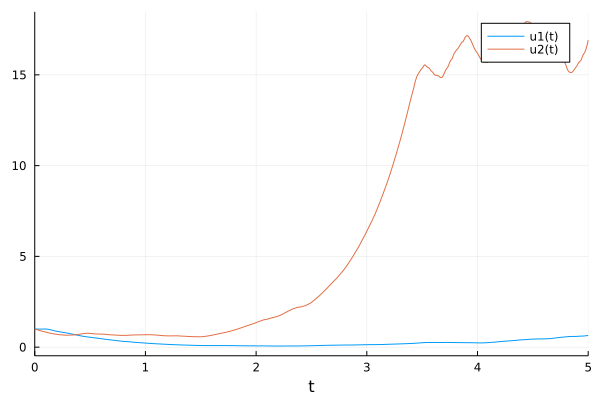

In [10]:
using DifferentialEquations
using Plots

function f(du, u, p, t, W)
  du[1] = 2u[1] * sin(W[1] - W[2])
  du[2] = -2u[2] * cos(W[1] + W[2])
end

u0 = [1.00, 1.00]
tspan = (0.0, 5.0)

prob = RODEProblem(f, u0, tspan)
sol = solve(prob, RandomEM(), dt=1/100)

plot(sol)

### Recommended RODE solvers

- `RandomEM`: The non-adpative, Euler-Maruyama method for RODEs. Currently the only implemented method.